MNIST Handwriting recognition with tensorflow

In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras.models import Sequential

In [2]:
# Local paths to data (fix paths when uploading to kaggle)
train_csv = '../data/train.csv'
test_csv = '../data/test.csv'

In [3]:
# Load dataset
# Small datasets can be read into memory directly ;)
train_dataset = pd.read_csv(train_csv)

In [4]:
# Info about datatype, number of examples, memory usage - very useful!
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
# Seperate the label from the features in the train dataset
train_features = train_dataset.copy()
train_labels = train_features.pop('label')

# Convert the features from a pandas dataframe into a numpy array
train_features = np.array(train_features)

In [6]:
train_features.shape

(42000, 784)

In [7]:
input_shape = train_features.shape[1]
print(input_shape)

784


In [8]:
train_labels.shape

(42000,)

In [9]:
train_labels[:10]

0    1
1    0
2    1
3    4
4    0
5    0
6    7
7    3
8    5
9    3
Name: label, dtype: int64

In [10]:
classes = set(train_labels)
num_classes = len(classes)
print(num_classes)

10


In [11]:
# We're done with the dataset, so let's clear it from memory
del train_dataset
gc.collect()

23

Vanilla Neural Network Approach

In [12]:
vanilla_model = tf.keras.Sequential([
  layers.InputLayer(input_shape=input_shape),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])



In [13]:
vanilla_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [14]:
vanilla_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(0.001),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [15]:
vanilla_history = vanilla_model.fit(train_features,
                                    train_labels,
                                    validation_split=0.2,
                                    batch_size=32,
                                    epochs=10)


Epoch 1/10
1050/1050 [==============================] - 5s 4ms/step - loss: 4.3621 - sparse_categorical_accuracy: 0.8518 - val_loss: 0.9128 - val_sparse_categorical_accuracy: 0.8563
Epoch 2/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.5428 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.8942
Epoch 3/10
1050/1050 [==============================] - 5s 5ms/step - loss: 0.3545 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.4195 - val_sparse_categorical_accuracy: 0.9187
Epoch 4/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.3050 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.4521 - val_sparse_categorical_accuracy: 0.9176
Epoch 5/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.9306 - val_loss: 0.3536 - val_sparse_categorical_accuracy: 0.9300
Epoch 6/10
1050/1050 [==============================] - 5s 4ms/step - loss: 0.2501 - spars

The vanilla model achieves 90%+ accuracy quickly.  Let's look at the training curve and evaluate it.

In [16]:
vanilla_history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

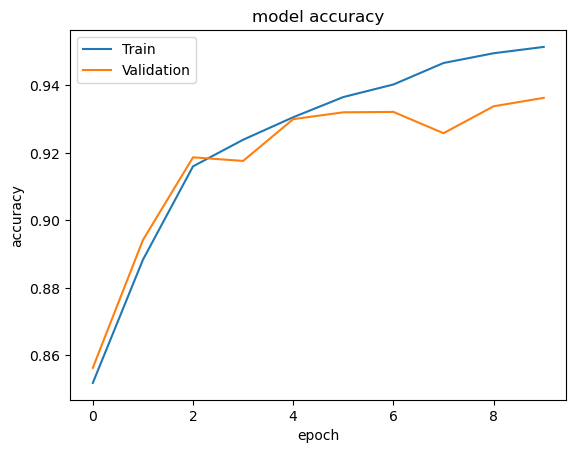

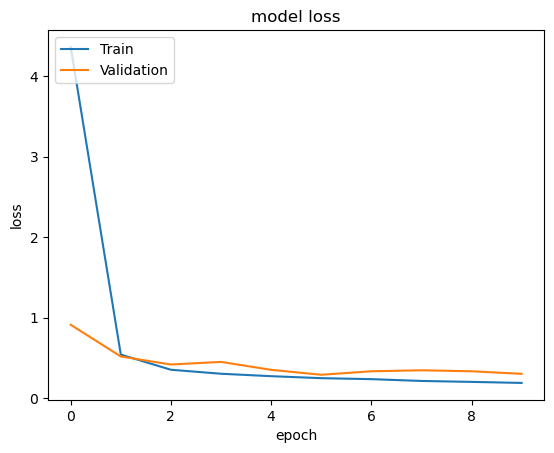

In [17]:
# summarize history for accuracy
plt.plot(vanilla_history.history['sparse_categorical_accuracy'])
plt.plot(vanilla_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vanilla_history.history['loss'])
plt.plot(vanilla_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We're slightly overtrained, looks like epoch 6 is the best accuracy on the test set.  
We will use this as our baseline to compare to our next model.

In [18]:
train_features.shape

(42000, 784)

In [19]:
cnn_train_set = train_features.reshape(42000,28,28,1)
input_shape = (28,28,1)

In [58]:
cnn_model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(num_classes*2, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ])

In [59]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1600)             

In [60]:
cnn_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(0.001),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [61]:
BATCH_SIZE = 32
EPOCHS = 10

In [62]:

cnn_history = cnn_model.fit(cnn_train_set,
                                    train_labels,
                                    validation_split=0.2,
                                    batch_size=BATCH_SIZE,
                                    epochs=EPOCHS)

Epoch 1/10
1050/1050 [==============================] - 41s 38ms/step - loss: 2.1138 - sparse_categorical_accuracy: 0.1967 - val_loss: 2.0171 - val_sparse_categorical_accuracy: 0.2104
Epoch 2/10
1050/1050 [==============================] - 43s 41ms/step - loss: 1.5374 - sparse_categorical_accuracy: 0.4339 - val_loss: 0.5507 - val_sparse_categorical_accuracy: 0.8785
Epoch 3/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.4447 - sparse_categorical_accuracy: 0.8576 - val_loss: 0.1089 - val_sparse_categorical_accuracy: 0.9733
Epoch 4/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.2639 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.1211 - val_sparse_categorical_accuracy: 0.9714
Epoch 5/10
1050/1050 [==============================] - 44s 41ms/step - loss: 0.2164 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.0780 - val_sparse_categorical_accuracy: 0.9792
Epoch 6/10
1050/1050 [==============================] - 43s 41ms/step - loss: 0.

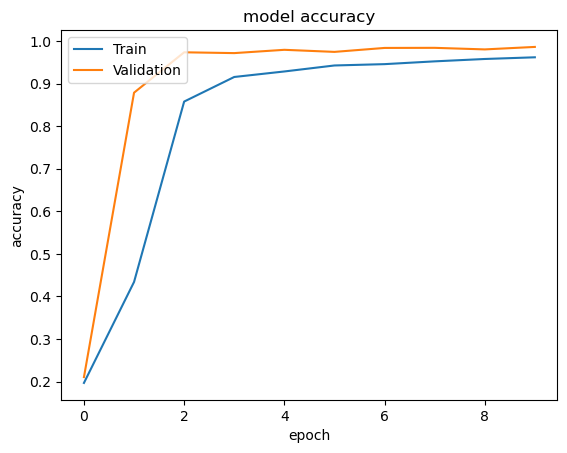

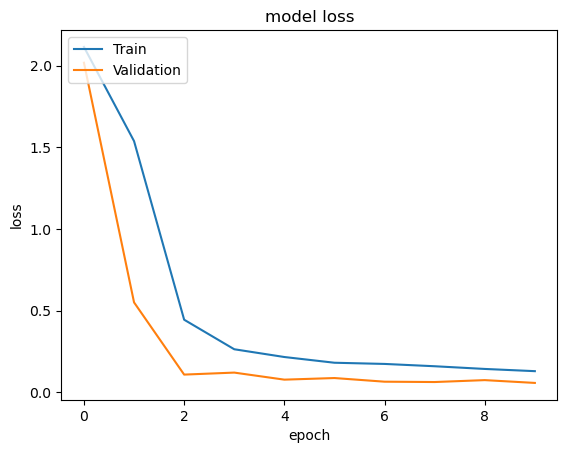

In [63]:
# summarize history for accuracy
plt.plot(cnn_history.history['sparse_categorical_accuracy'])
plt.plot(cnn_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Looks much better, with accuracy of 98%!  
Adding a dense layer and some dropout layers to help prevent overfitting looks like it worked pretty well.  The val_accuracy is higher than the train_accuracy, and the val_loss is less than the train_loss.

Predictions

In [64]:
test_dataset = pd.read_csv(test_csv)

In [65]:
test_dataset.shape

(28000, 784)

In [66]:
cnn_test_dataset = np.array(test_dataset).reshape(-1,28,28,1)

In [67]:
cnn_test_dataset.shape

(28000, 28, 28, 1)

In [69]:
predictions = cnn_model.predict(cnn_test_dataset)

875/875 [==============================] - 23s 26ms/step


In [70]:
predictions[1]

array([9.9378055e-01, 8.7821492e-09, 2.7352758e-04, 3.6379689e-08,
       3.3660124e-06, 1.5805270e-07, 5.6635514e-03, 2.8529703e-08,
       2.2941650e-04, 4.9310642e-05], dtype=float32)

In [71]:
predictions = np.argmax(predictions,axis=1)

In [72]:
predictions[:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3], dtype=int64)

In [73]:
results = pd.Series(predictions,name="Label")

In [74]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("sample_submission.csv",index=False)
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
